In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [ ]:
df = pd.read_csv("heart_disease.csv")
print("Initial Shape:", df.shape)
display(df.head())

**1.	IT24100271_Noice Reduction- Fernando M.K.J**

In [ ]:
for col in df.select_dtypes(include=["number"]).columns:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
for col in df.select_dtypes(include=["number"]).columns:
    if col != "target":
        df[col+"_smooth"] = df[col].rolling(window=3, center=True, min_periods=1).median()

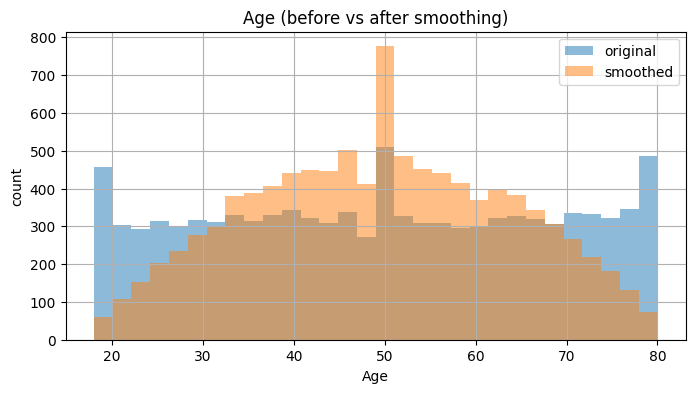

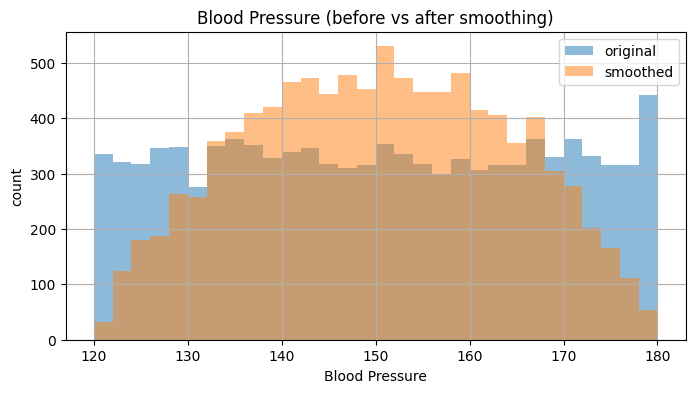

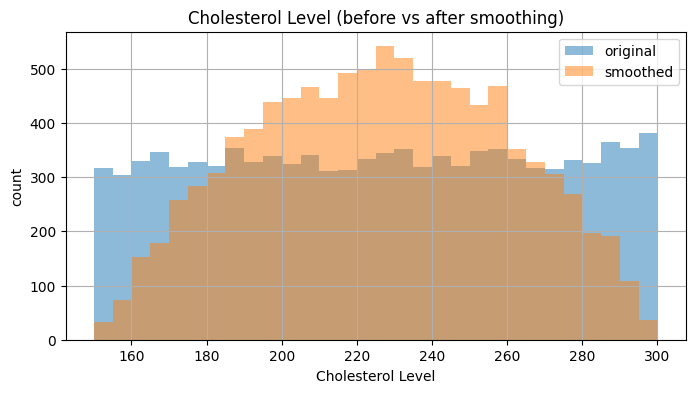

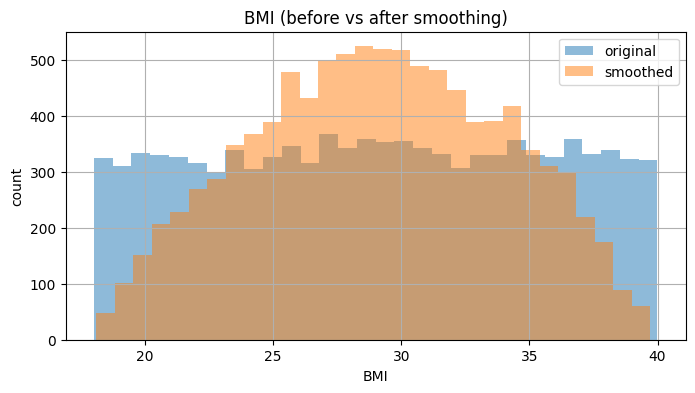

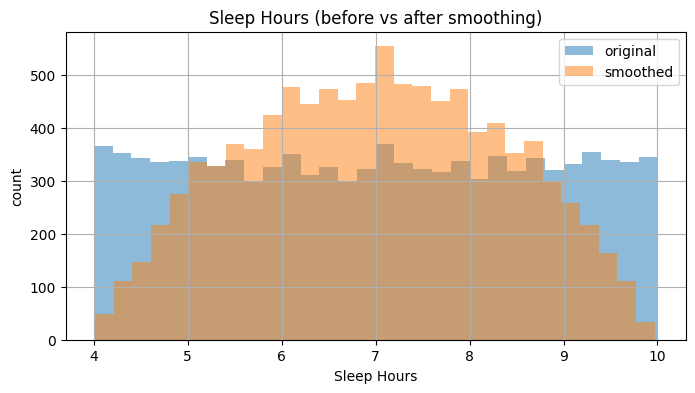

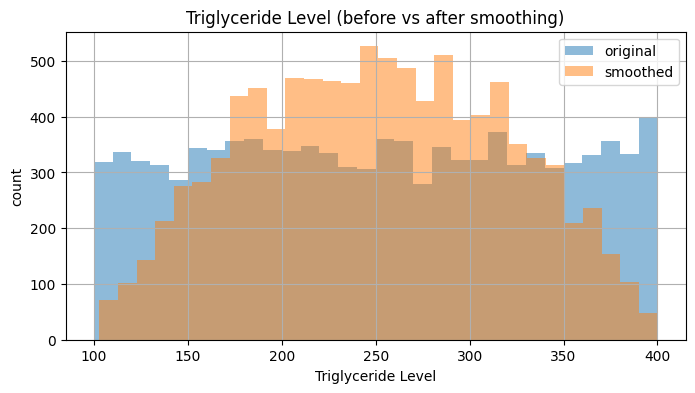

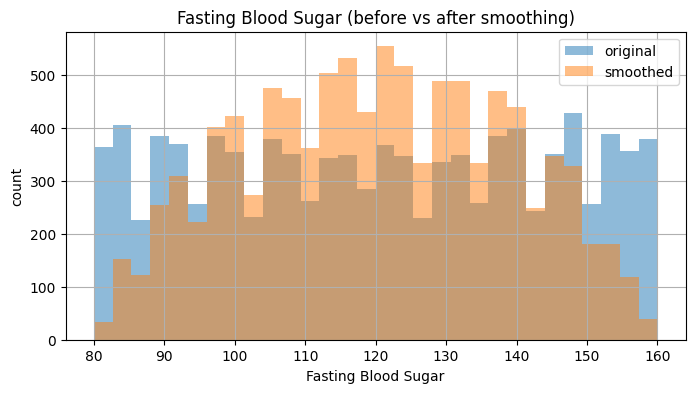

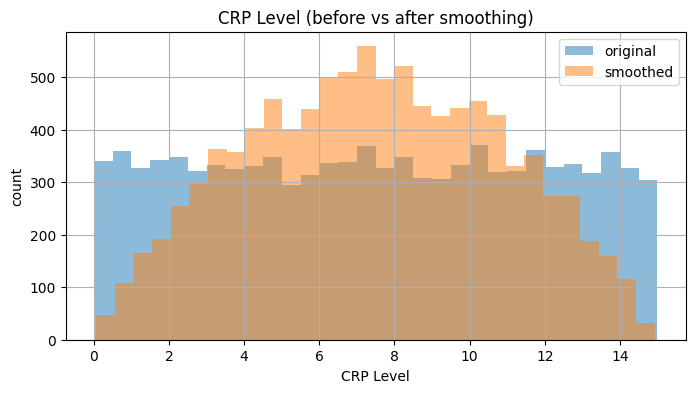

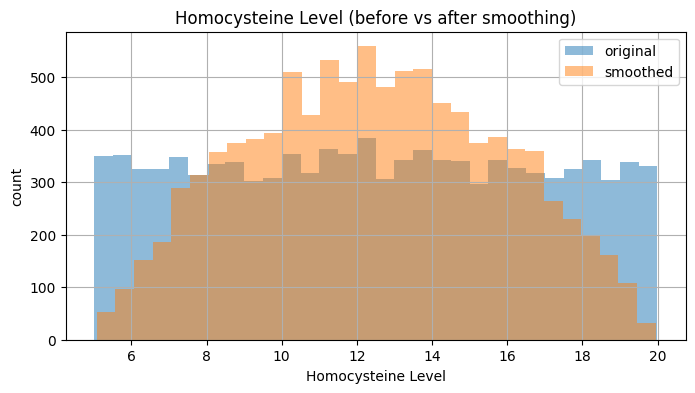

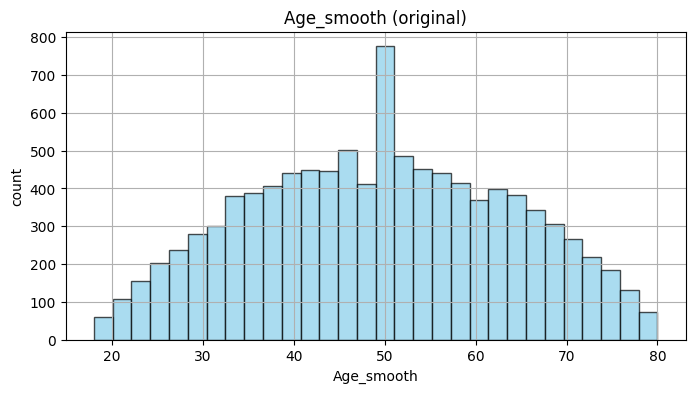

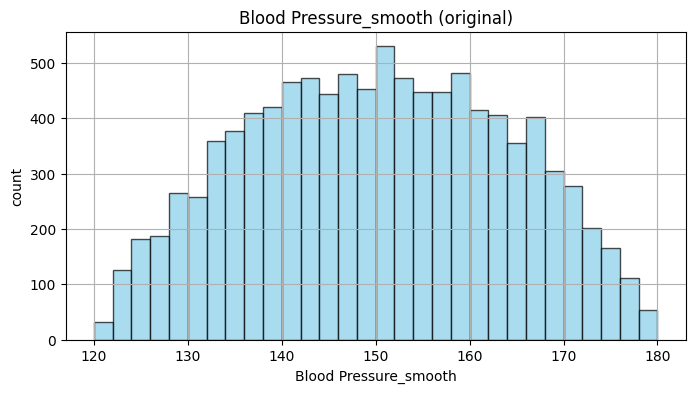

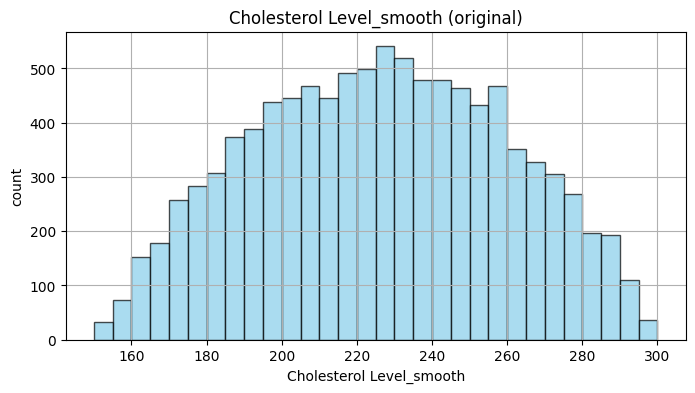

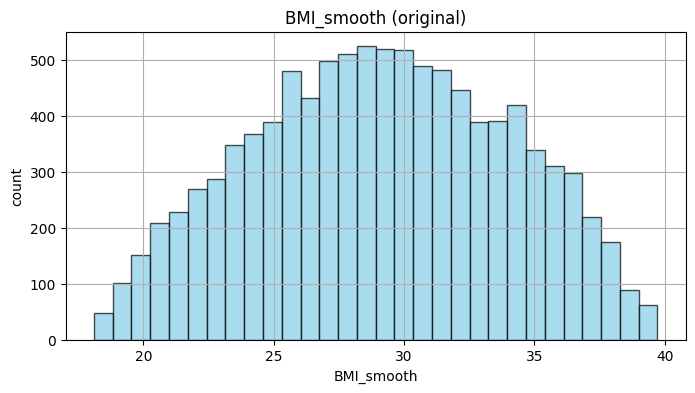

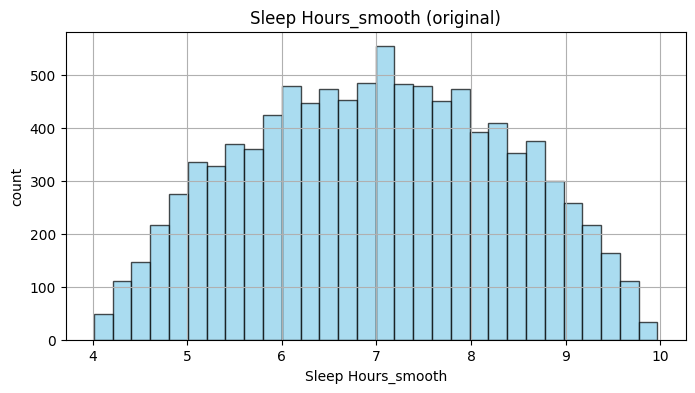

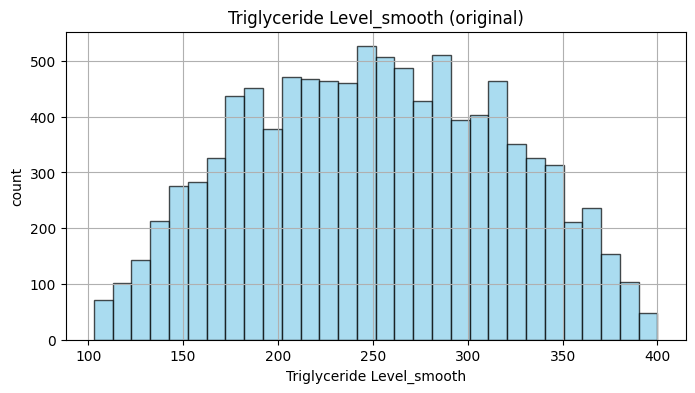

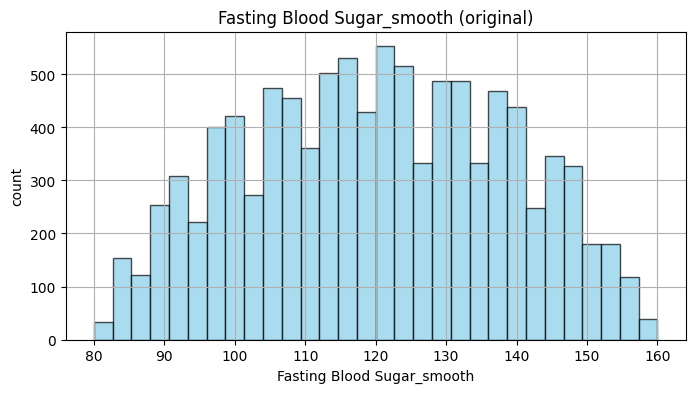

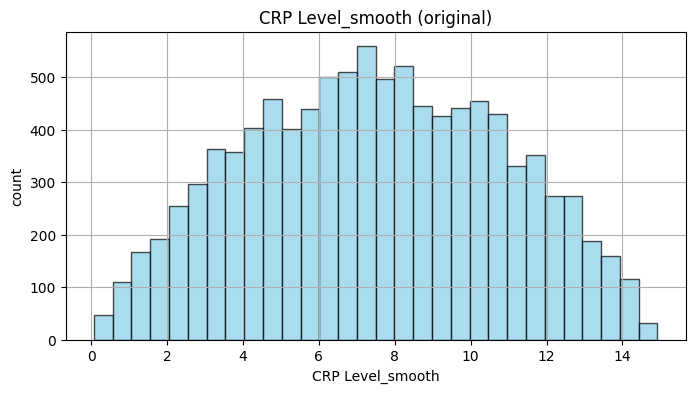

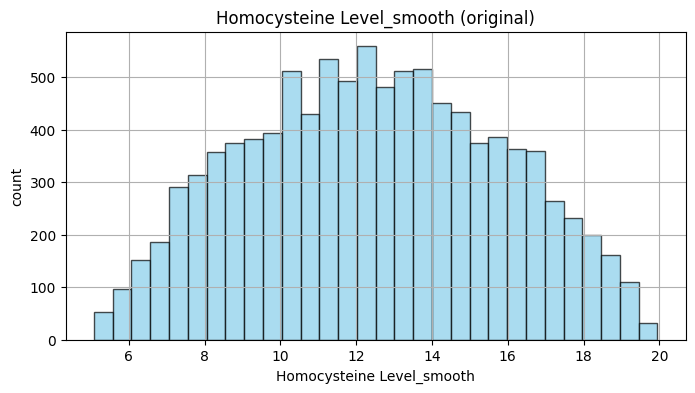

In [ ]:
# 4) Histograms (original vs smoothed for ALL numeric features)
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
if "target" in num_cols:
    num_cols.remove("target")

for col in num_cols:
    plt.figure(figsize=(8,4))
    if col+"_smooth" in df.columns:
        df[col].hist(bins=30, alpha=0.5, label="original")
        df[col+"_smooth"].hist(bins=30, alpha=0.5, label="smoothed")
        plt.title(f"{col} (before vs after smoothing)")
        plt.legend()
    else:
        df[col].hist(bins=30, alpha=0.7, color="skyblue", edgecolor="black")
        plt.title(f"{col} (original)")
    plt.xlabel(col); plt.ylabel("count")
    plt.show()

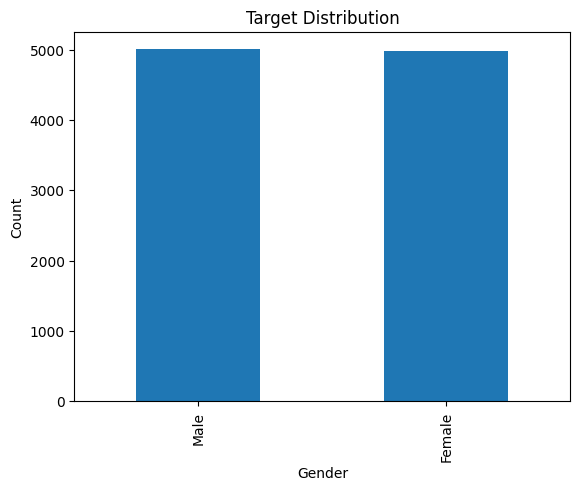

In [ ]:
aliases = {"target","output","label","y","class"}
tcol = next((c for c in df.columns if c in aliases), None)

if tcol is None:  # fallback: pick first binary column
    bin_cols = [c for c in df.columns if df[c].nunique() == 2]
    tcol = bin_cols[0]

df[tcol].value_counts().plot(kind="bar", title="Target Distribution")
plt.xlabel(tcol)
plt.ylabel("Count")
plt.show()

In [ ]:

y = df["Heart Disease Status"]
X = df.drop(columns=["Heart Disease Status"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessor: OneHotEncode categorical + passthrough numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Transform training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train_processed, y_train)

# Predict
y_pred = rf.predict(X_test_processed)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

          No       0.80      1.00      0.89      1600
         Yes       0.00      0.00      0.00       400

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**2.IT24100330_Encoding categorical variables - Isuru**

In [ ]:
# Separate features and target
X = df.drop("Heart Disease Status", axis=1)
y = df["Heart Disease Status"]

# Apply One-Hot Encoding to selected categorical variables (excluding target)
categorical_cols = [
    "Gender", "Exercise Habits", "Smoking", "Family Heart Disease", "Diabetes",
    "High Blood Pressure", "Low HDL Cholesterol", "High LDL Cholesterol",
    "Alcohol Consumption", "Stress Level", "Sugar Consumption"
]

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Shape before encoding:", X.shape)
print("Shape after encoding:", X_encoded.shape)


Shape before encoding: (10000, 29)
Shape after encoding: (10000, 33)


In [ ]:
#Combine encoded features with target for display
df_encoded = pd.concat([X_encoded, y], axis=1)

#Display encoded dataset
print("Encoded dataset shape:", df_encoded.shape)
print(df_encoded.head())

Encoded dataset shape: (10000, 34)
    Age  Blood Pressure  Cholesterol Level        BMI  Sleep Hours  \
0  56.0           153.0              155.0  24.991591     7.633228   
1  69.0           146.0              286.0  25.221799     8.744034   
2  46.0           126.0              216.0  29.855447     4.440440   
3  32.0           122.0              293.0  24.130477     5.249405   
4  60.0           166.0              242.0  20.486289     7.030971   

   Triglyceride Level  Fasting Blood Sugar  CRP Level  Homocysteine Level  \
0               342.0                120.0  12.969246           12.387250   
1               133.0                157.0   9.355389           19.298875   
2               393.0                 92.0  12.709873           11.230926   
3               293.0                 94.0  12.509046            5.961958   
4               263.0                154.0  10.381259            8.153887   

   Age_smooth  ...  High Blood Pressure_Yes  Low HDL Cholesterol_Yes  \
0        

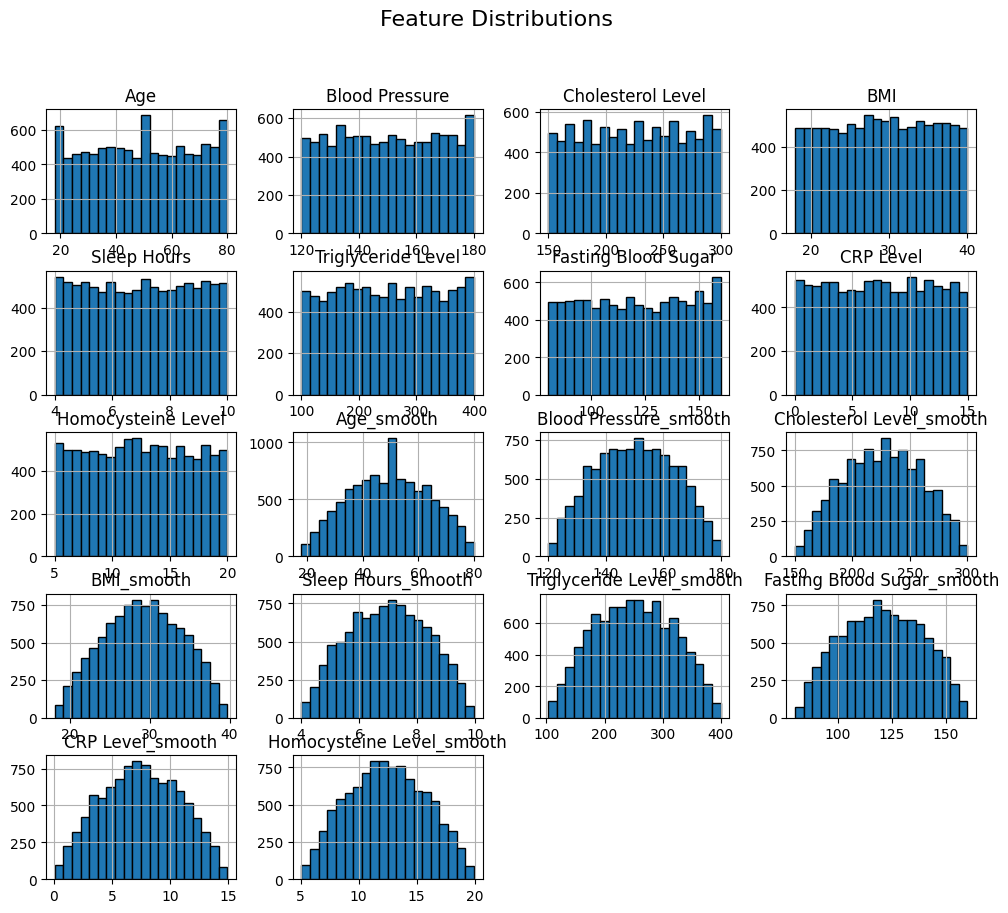

In [ ]:
#Histogram of features
df.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

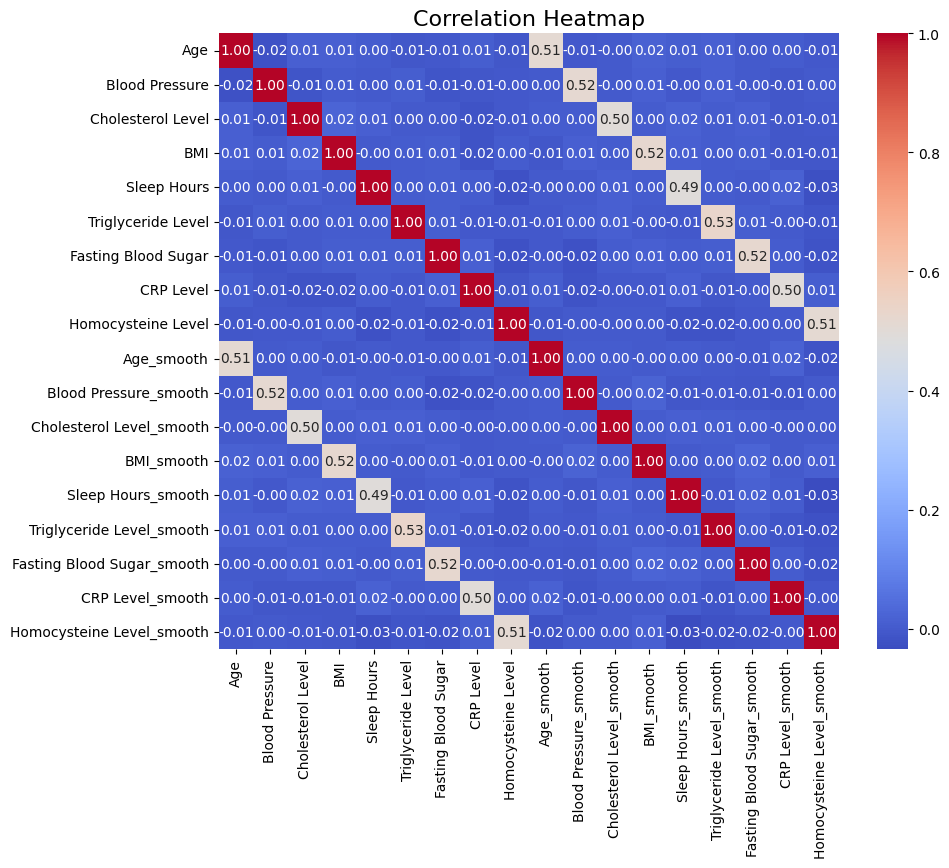

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", cbar=True,
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

**3.	IT24100370- Abeysekara J.S.P.L -Outlier removal**

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

#Function to remove outliers using IQR
def remove_outliers_iqr(data, columns):
    cleaned_data = data.copy()
    for col in columns:
        Q1 = cleaned_data[col].quantile(0.25)
        Q3 = cleaned_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_data = cleaned_data[
            (cleaned_data[col] >= lower_bound) & (cleaned_data[col] <= upper_bound)
        ]
    return cleaned_data

#Apply outlier removal
df_cleaned = remove_outliers_iqr(df, numeric_cols)

print("Shape before:", df.shape)
print("Shape after:", df_cleaned.shape)

Shape before: (10000, 30)
Shape after: (10000, 30)


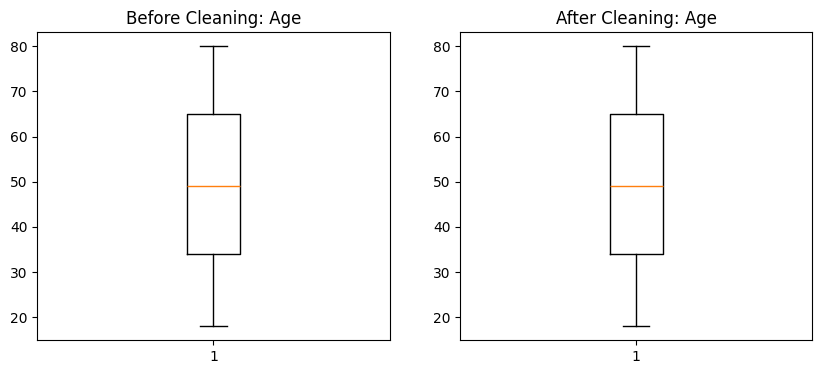

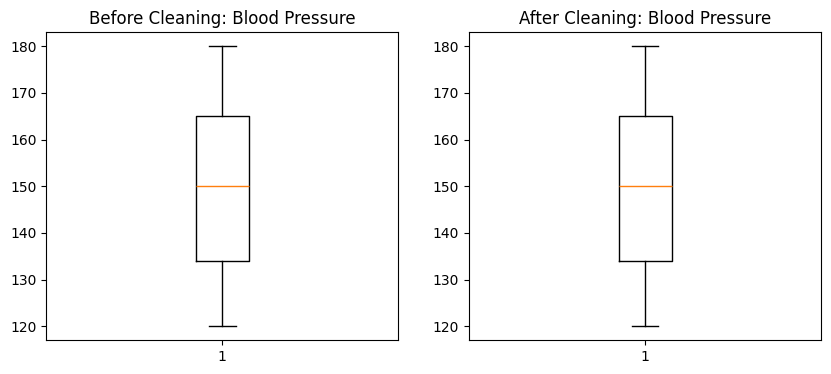

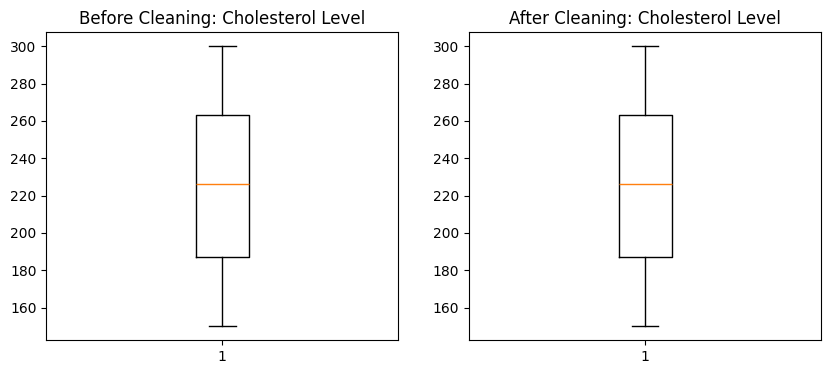

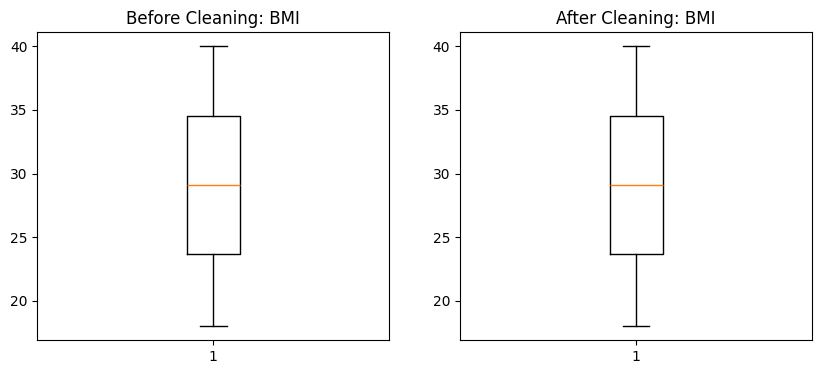

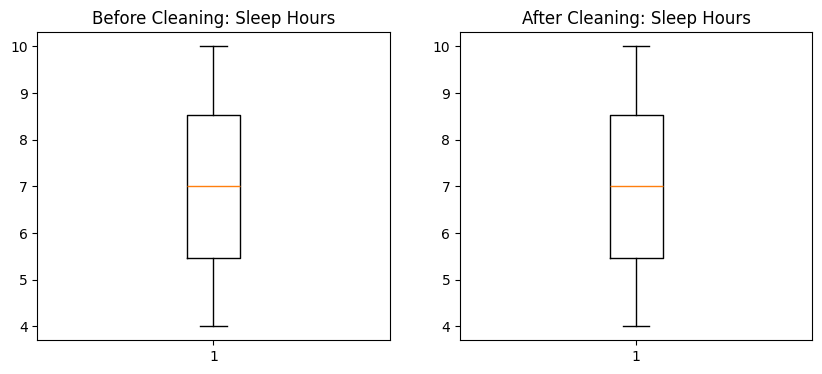

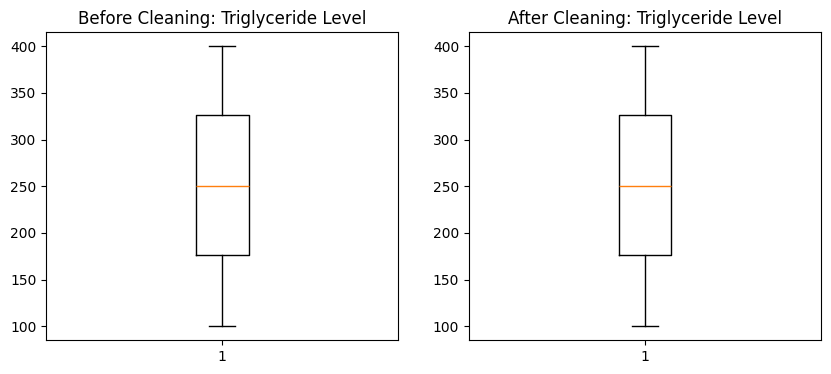

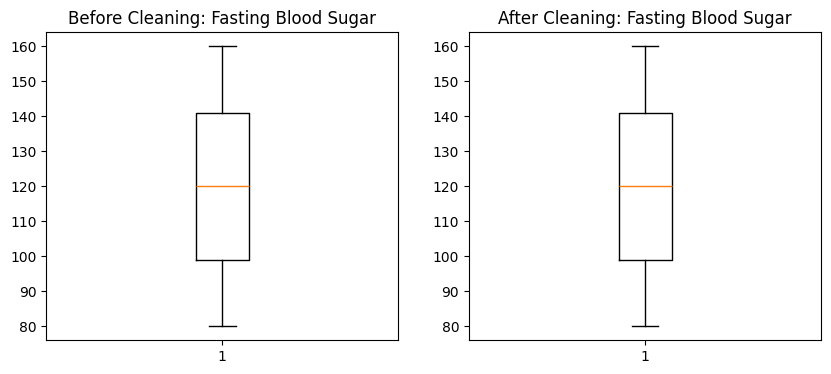

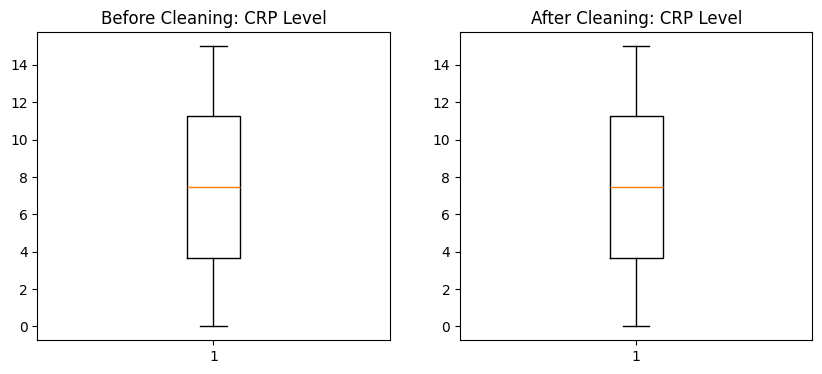

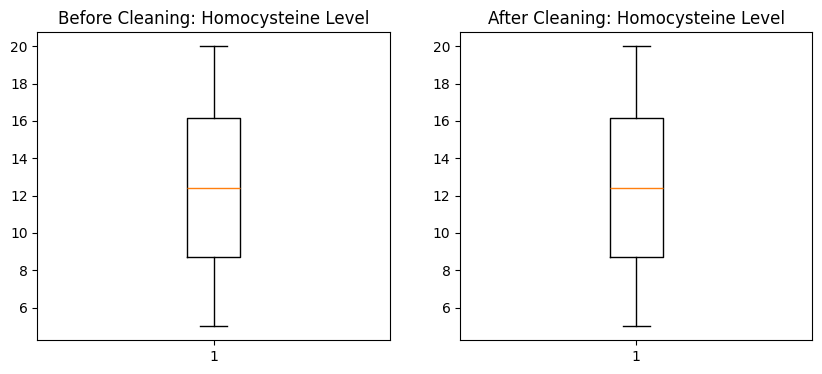

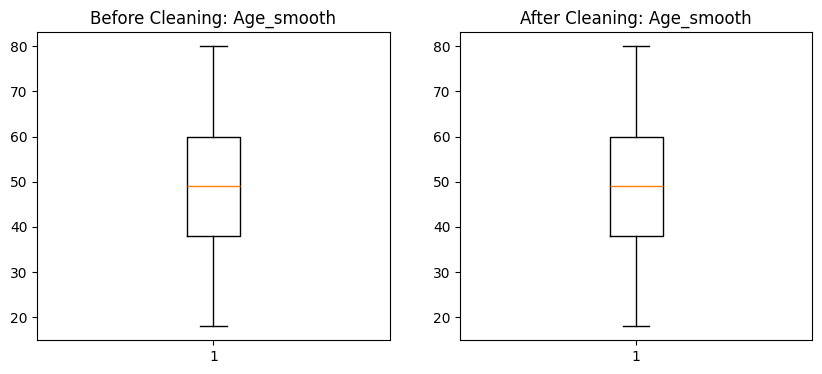

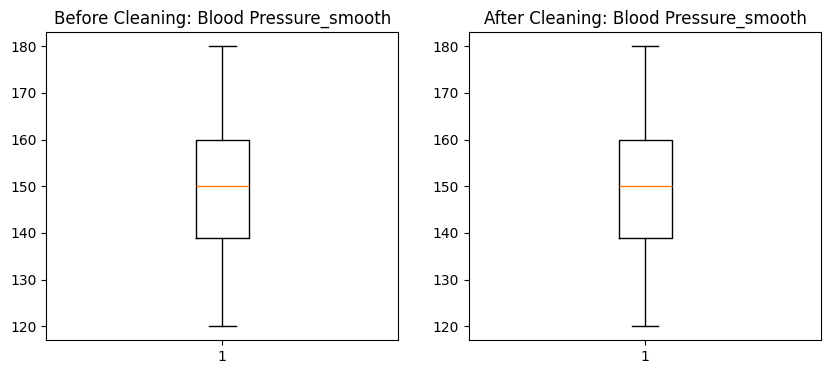

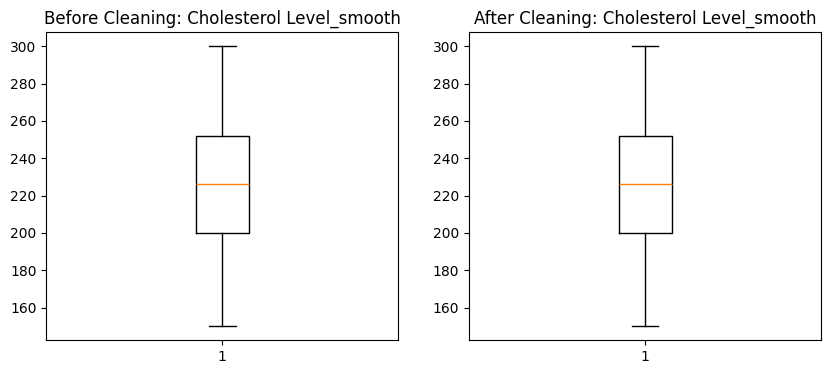

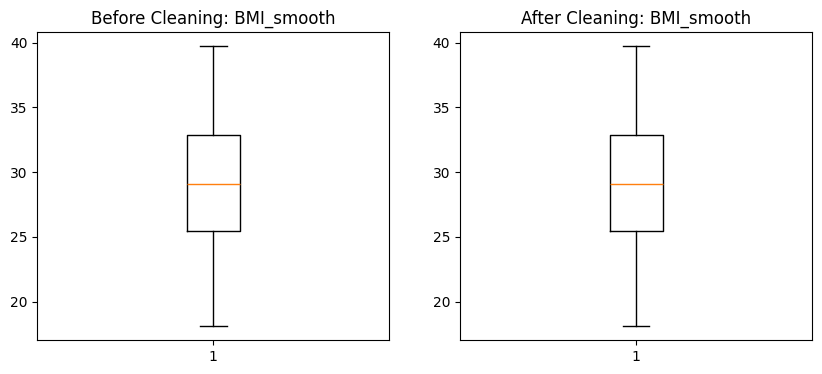

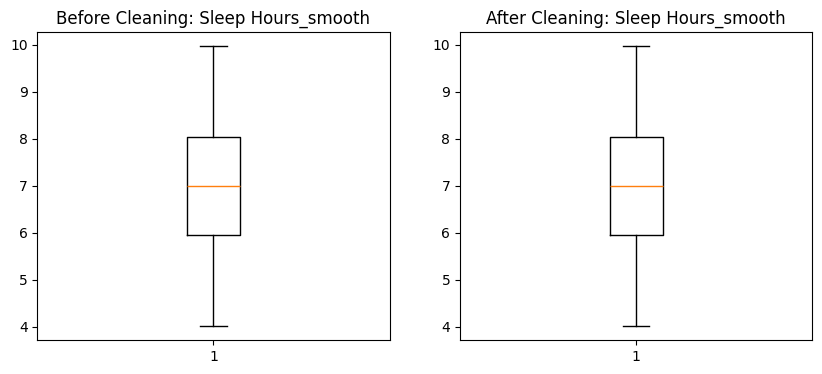

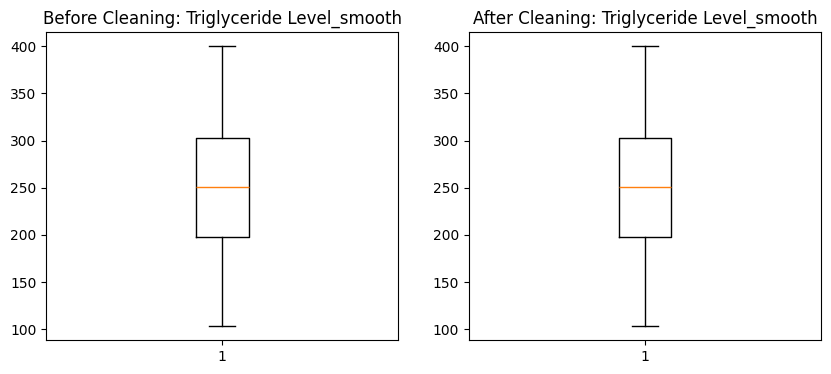

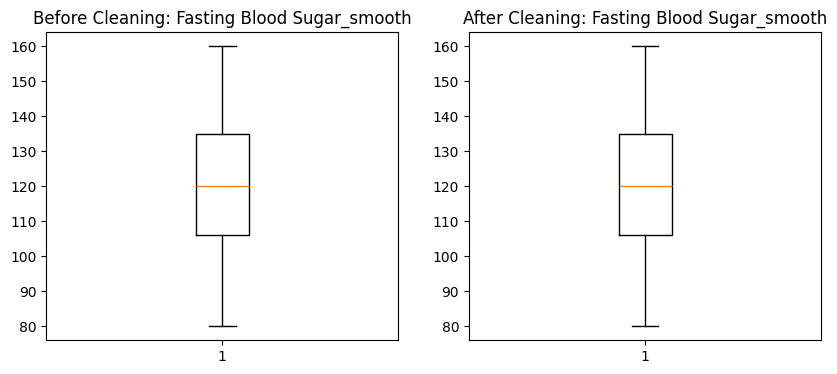

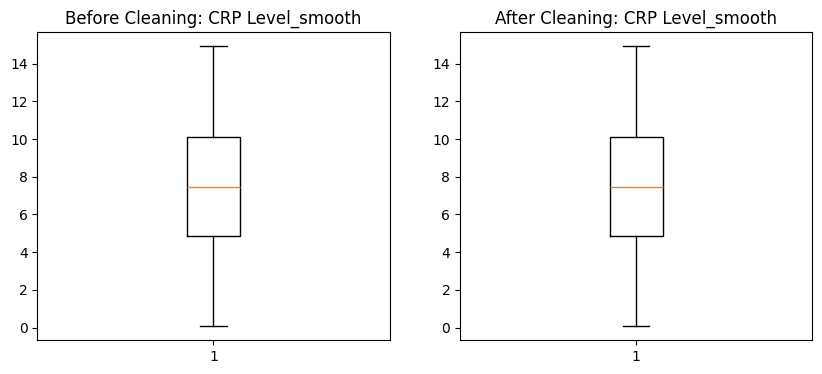

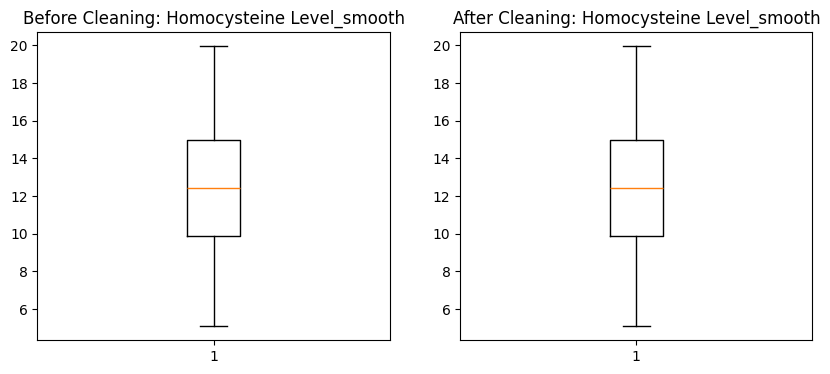

In [ ]:
#Boxplots for each feature
def plot_boxplots_before_after(original, cleaned, columns):
    for col in columns:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Before cleaning
        axes[0].boxplot(original[col].dropna())
        axes[0].set_title(f"Before Cleaning: {col}")

        # After cleaning
        axes[1].boxplot(cleaned[col].dropna())
        axes[1].set_title(f"After Cleaning: {col}")

        plt.show()

#Call function
plot_boxplots_before_after(df, df_cleaned, numeric_cols)

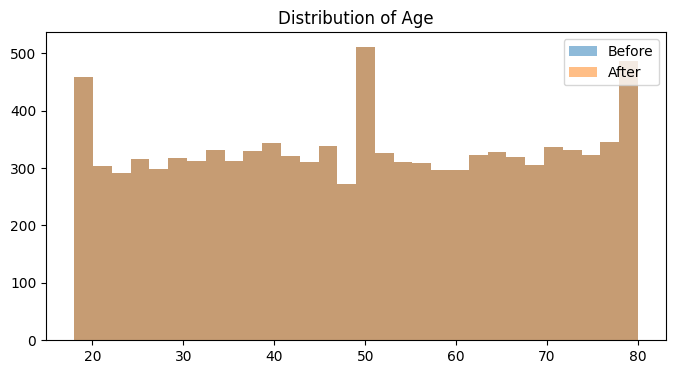

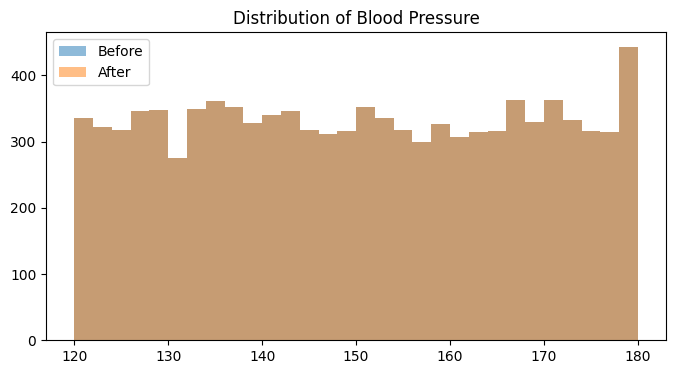

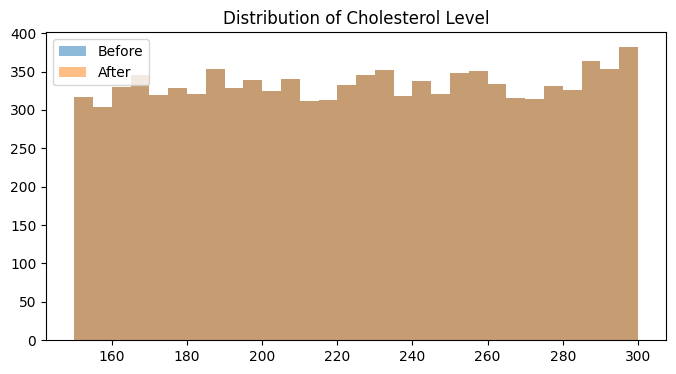

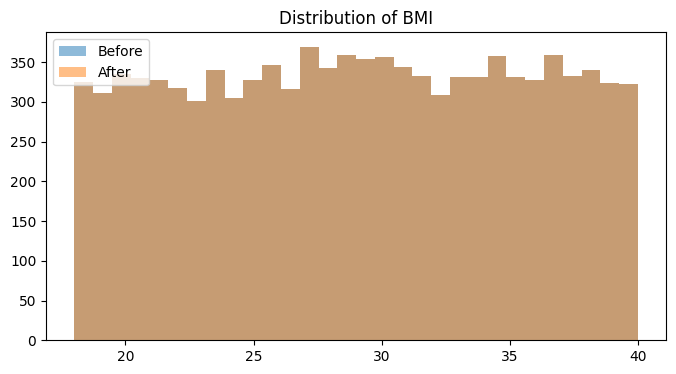

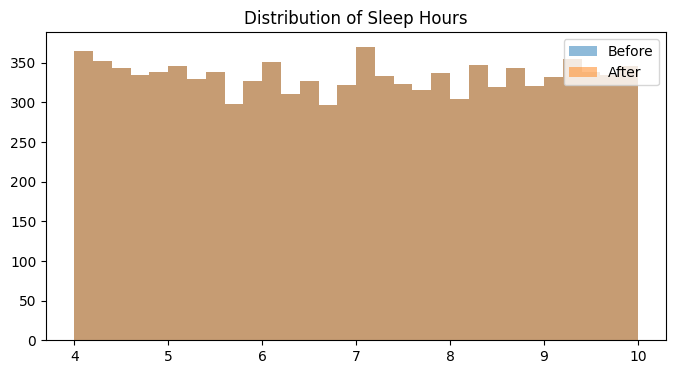

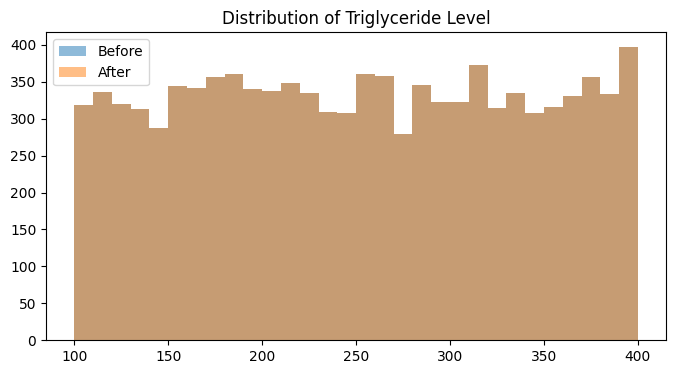

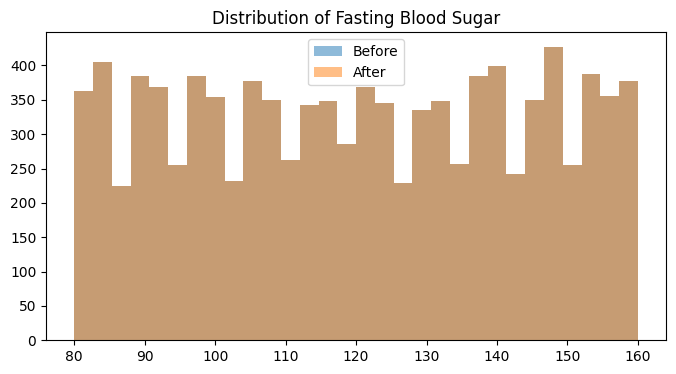

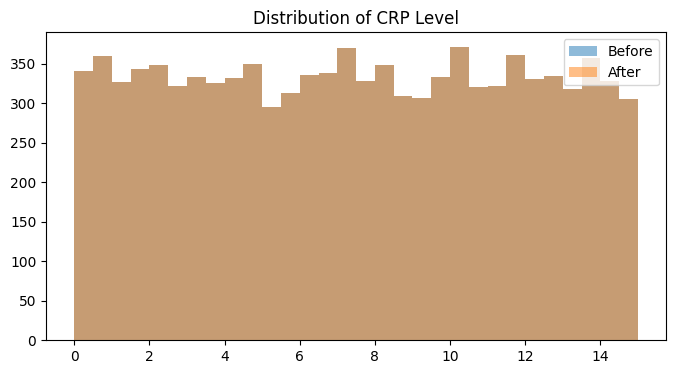

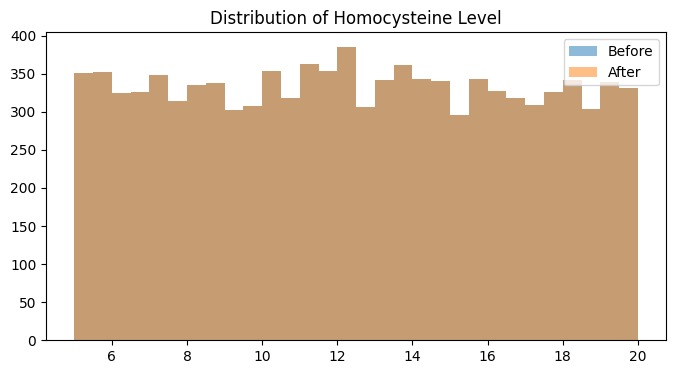

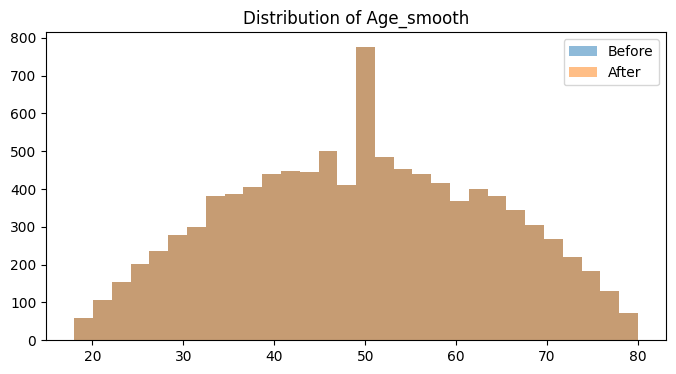

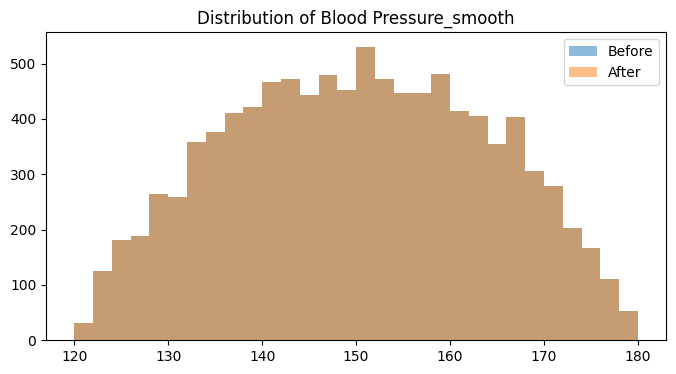

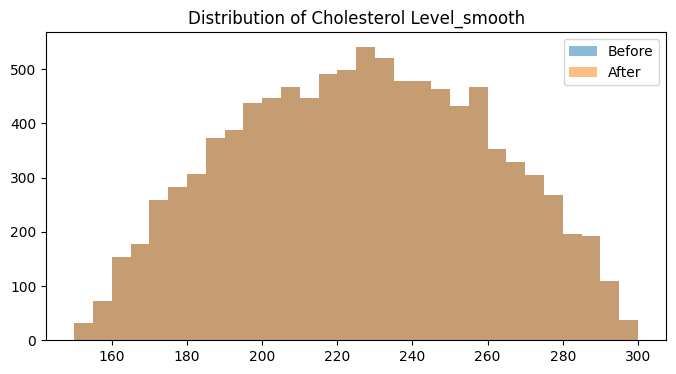

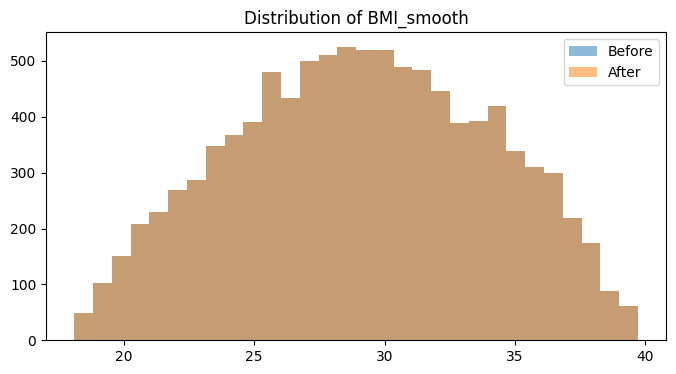

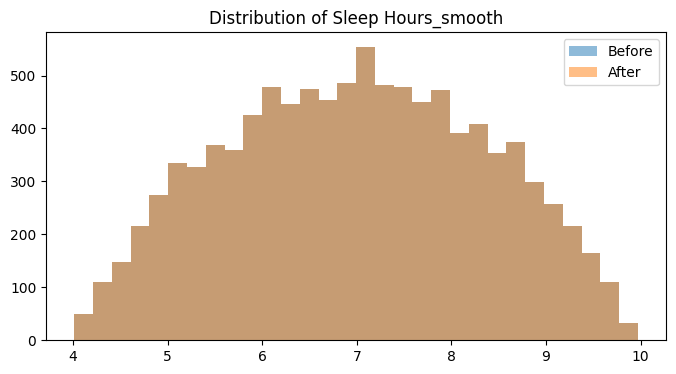

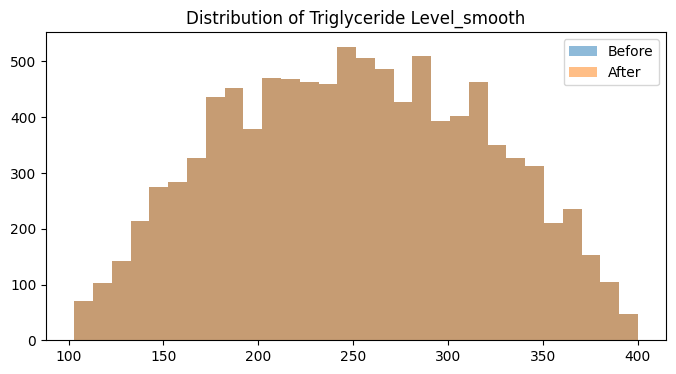

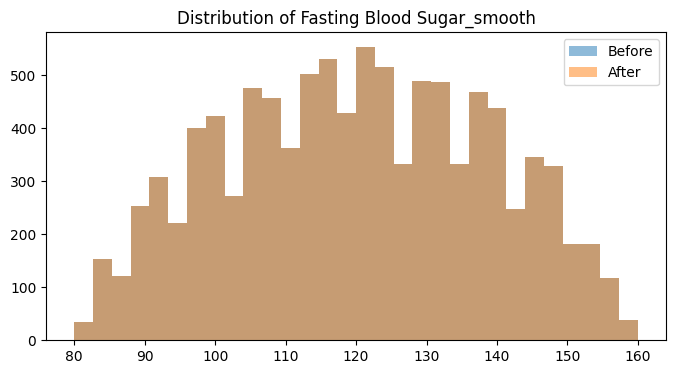

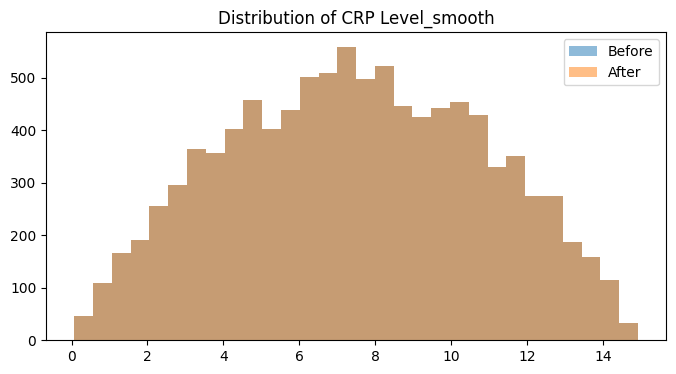

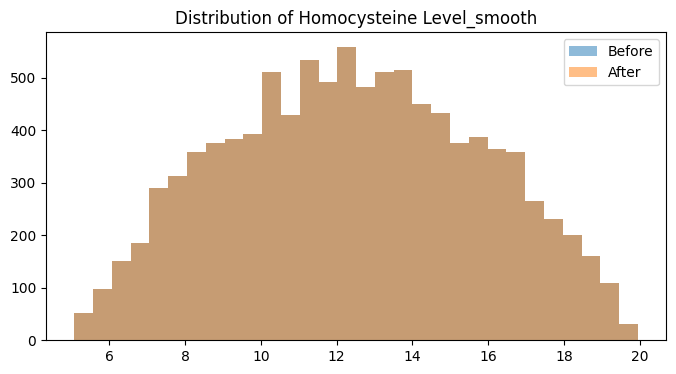

In [ ]:
#Histograms for each feature
def plot_histograms_before_after(original, cleaned, columns):
    for col in columns:
        plt.figure(figsize=(8,4))
        plt.hist(original[col], bins=30, alpha=0.5, label='Before')
        plt.hist(cleaned[col], bins=30, alpha=0.5, label='After')
        plt.title(f"Distribution of {col}")
        plt.legend()
        plt.show()

#Call function
plot_histograms_before_after(df, df_cleaned, numeric_cols)

**4.IT24100301-Methpani M M K
bold text- Normalization / scaling**


No major outliers detected → Applying Min-Max Scaling


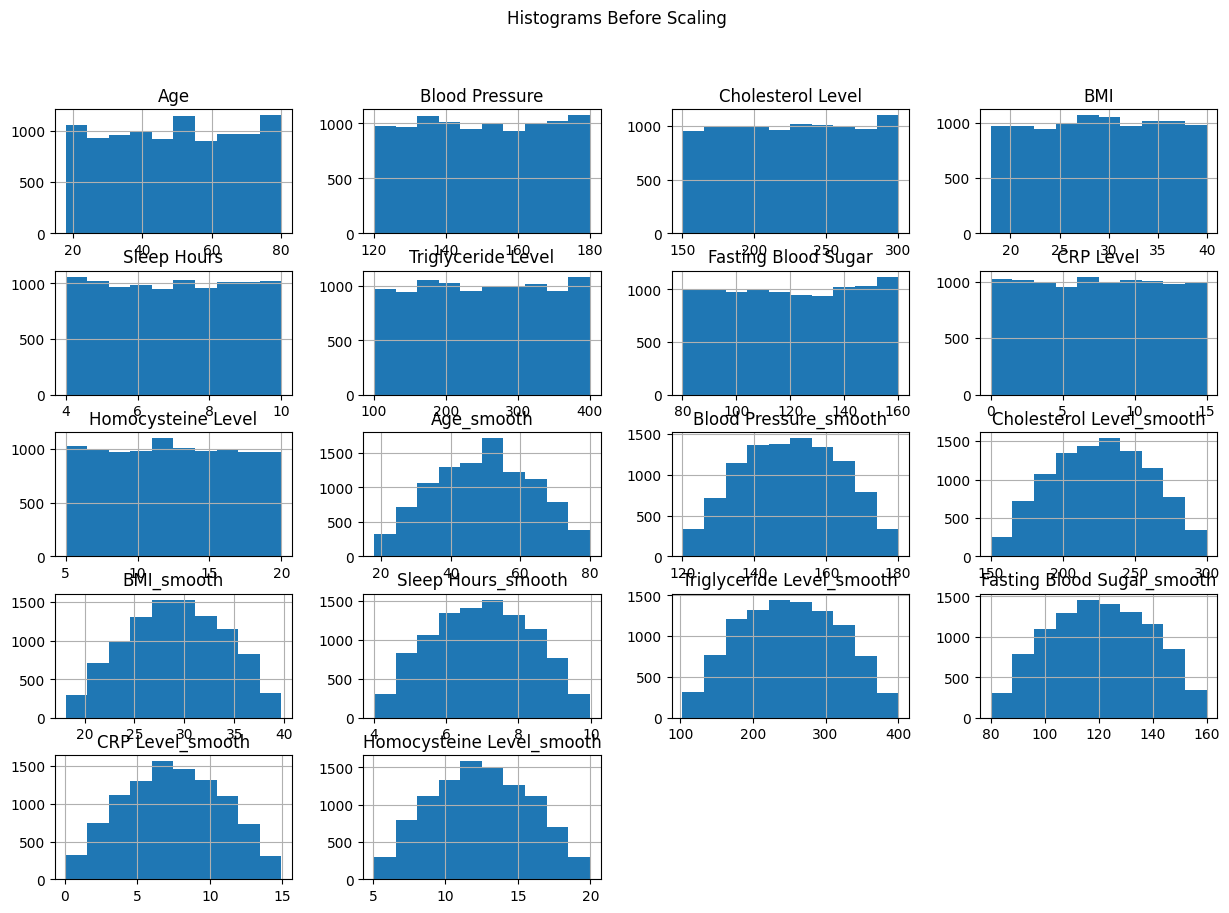

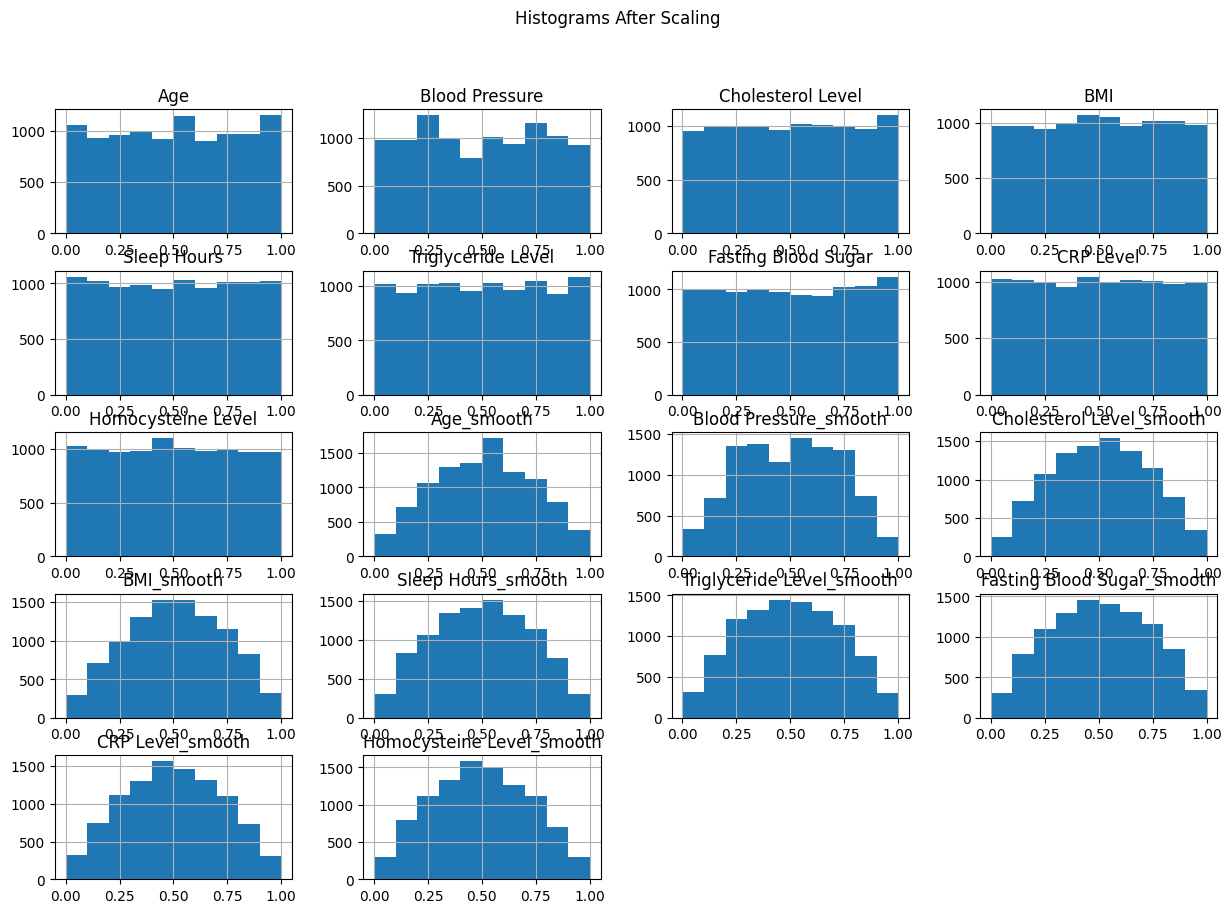

In [ ]:
X = df.drop("Heart Disease Status", axis=1)
y = df["Heart Disease Status"]

# Select numeric columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

outliers_exist = False
for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    if ((X[col] < lower) | (X[col] > upper)).any():
        outliers_exist = True
        print(f"Outliers found in column: {col}")

# Scaling only numeric columns
if not outliers_exist:
    print("\nNo major outliers detected → Applying Min-Max Scaling")

    # Histograms before scaling
    X[numeric_cols].hist(figsize=(15, 10))
    plt.suptitle("Histograms Before Scaling")
    plt.show()

    scaler = MinMaxScaler()
    X_scaled_numeric = pd.DataFrame(scaler.fit_transform(X[numeric_cols]),
                                    columns=numeric_cols)

else:
    print("\nOutliers detected → Applying Standardization Scaling")

    # Histograms before scaling
    X[numeric_cols].hist(figsize=(15, 10))
    plt.suptitle("Histograms Before Scaling")
    plt.show()

    scaler = StandardScaler()
    X_scaled_numeric = pd.DataFrame(scaler.fit_transform(X[numeric_cols]),
                                    columns=numeric_cols)

# Replace only numeric columns with scaled values
X_scaled = X.copy()
X_scaled[numeric_cols] = X_scaled_numeric

# Histograms after scaling
X_scaled[numeric_cols].hist(figsize=(15, 10))
plt.suptitle("Histograms After Scaling")
plt.show()

**5.IT24100370_Handling Imabalace data - Gamlaksha G.D.A.S**

In [ ]:
print("Shape before cleaning:", df.shape)
print(df.head(), "\n")
print("Columns:", df.columns, "\n")

Shape before cleaning: (10000, 30)
    Age  Gender  Blood Pressure  Cholesterol Level Exercise Habits Smoking  \
0  56.0    Male           153.0              155.0            High     Yes   
1  69.0  Female           146.0              286.0            High      No   
2  46.0    Male           126.0              216.0             Low      No   
3  32.0  Female           122.0              293.0            High     Yes   
4  60.0    Male           166.0              242.0             Low     Yes   

  Family Heart Disease Diabetes        BMI High Blood Pressure  ...  \
0                  Yes       No  24.991591                 Yes  ...   
1                  Yes      Yes  25.221799                  No  ...   
2                   No       No  29.855447                  No  ...   
3                  Yes       No  24.130477                 Yes  ...   
4                  Yes      Yes  20.486289                 Yes  ...   

  Heart Disease Status Age_smooth Blood Pressure_smooth  \
0         

In [ ]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [ ]:
# Plot before duplicate removal
plt.figure(figsize=(10,4))

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

Text(0, 0.5, 'Count')

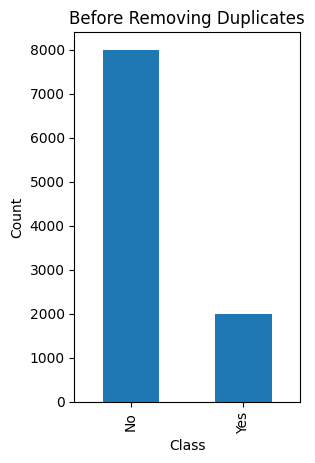

In [ ]:
plt.subplot(1, 2, 1)
df['Heart Disease Status'].value_counts().plot(kind='bar', title="Before Removing Duplicates")
plt.xlabel("Class")
plt.ylabel("Count")

In [ ]:
df = df.drop_duplicates()

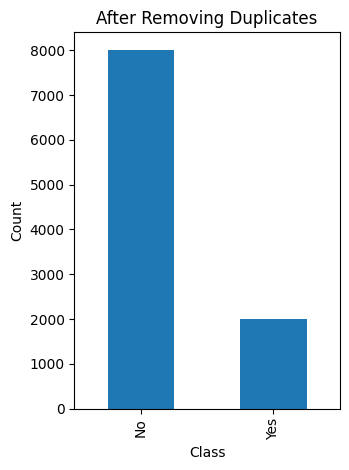

Dataset shape after removing duplicates: (10000, 30)


In [ ]:
plt.subplot(1, 2, 2)
df['Heart Disease Status'].value_counts().plot(kind='bar', title="After Removing Duplicates")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Dataset shape after removing duplicates: {df.shape}")

In [ ]:
# Handling missing values
# Identify numerical and categorical columns
numerical_cols = ['Age', 'Blood Pressure', 'Cholesterol Level', 'BMI', 'Sleep Hours',
                  'Triglyceride Level', 'Fasting Blood Sugar', 'CRP Level', 'Homocysteine Level']
categorical_cols = ['Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes',
                    'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol',
                    'Alcohol Consumption', 'Stress Level', 'Sugar Consumption']

In [ ]:
# Impute numerical columns with median
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Impute categorical columns with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("✅ Missing values handled successfully")
print("Shape after handling missing values:", df.shape)

✅ Missing values handled successfully
Shape after handling missing values: (10000, 30)


In [ ]:
# Check class distribution before balancing
print("Class distribution before balancing:")
print(df['Heart Disease Status'].value_counts(normalize=True))
print(df['Heart Disease Status'].value_counts())

Class distribution before balancing:
Heart Disease Status
No     0.8
Yes    0.2
Name: proportion, dtype: float64
Heart Disease Status
No     8000
Yes    2000
Name: count, dtype: int64


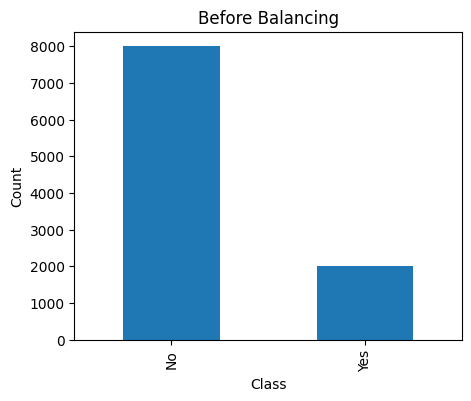

In [ ]:
# Plot class distribution before balancing
plt.figure(figsize=(5, 4))
df['Heart Disease Status'].value_counts().plot(kind='bar', title="Before Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
# Handle imbalance by oversampling the minority class using random sampling with replacement
counts = df['Heart Disease Status'].value_counts()
major_class = counts.idxmax()
minor_class = counts.idxmin()

df_major = df[df['Heart Disease Status'] == major_class]
df_minor = df[df['Heart Disease Status'] == minor_class]

# Oversample the minority class to match the majority class size
df_minor_oversampled = df_minor.sample(len(df_major), replace=True, random_state=42)

# Combine majority and oversampled minority
df_balanced = pd.concat([df_major, df_minor_oversampled], axis=0)

# Shuffle the balanced dataframe (optional but recommended)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Imbalanced data handled successfully (oversampling minority class)")
print("Shape after balancing:", df_balanced.shape)

✅ Imbalanced data handled successfully (oversampling minority class)
Shape after balancing: (16000, 30)


In [ ]:
# Check class distribution after balancing
print("Class distribution after balancing:")
print(df_balanced['Heart Disease Status'].value_counts(normalize=True))
print(df_balanced['Heart Disease Status'].value_counts())

Class distribution after balancing:
Heart Disease Status
Yes    0.5
No     0.5
Name: proportion, dtype: float64
Heart Disease Status
Yes    8000
No     8000
Name: count, dtype: int64


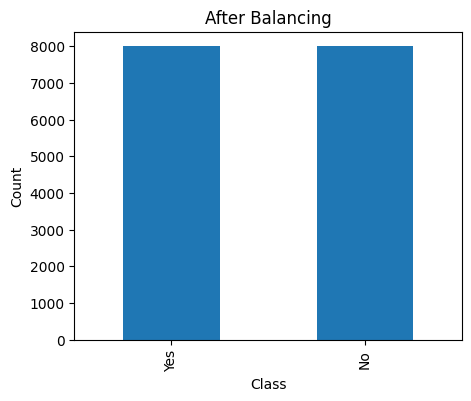

In [ ]:
# Plot class distribution after balancing
plt.figure(figsize=(5, 4))
df_balanced['Heart Disease Status'].value_counts().plot(kind='bar', title="After Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**6.	IT24100294-De Silva W.A.V.A-Feature engineering**

In [ ]:
# ---------------- Preprocessing ----------------
# Separate numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [ ]:
X = df.drop("Heart Disease Status", axis=1)  # Features
y = df["Heart Disease Status"]               # Target

In [ ]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fill NaNs with most frequent
    ("encoder", OneHotEncoder(handle_unknown="ignore"))    # one-hot encode
])

In [ ]:

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# ColumnTransformer: apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [ ]:
# ---------------- Feature Selection ----------------
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_classif, k=8))
])

In [ ]:
# Fit pipeline
X_new = pipeline.fit_transform(X, y)

# ---------------- Get Feature Names ----------------
# Numeric features remain the same
# For categorical → get OneHotEncoder names
feature_names = list(numeric_features) + list(
    pipeline.named_steps["preprocessor"]
            .named_transformers_["cat"]
            .named_steps["onehot"]
            .get_feature_names_out(categorical_features)
)

In [ ]:
# Select top k features
selected_features = [
    feature_names[i]
    for i, mask in enumerate(pipeline.named_steps["feature_selection"].get_support())
    if mask
]

print("Selected Features:", selected_features)

Selected Features: ['BMI', 'Blood Pressure_smooth', 'BMI_smooth', 'Homocysteine Level_smooth', 'Gender_Female', 'Gender_Male', 'Stress Level_Low', 'Stress Level_Medium']


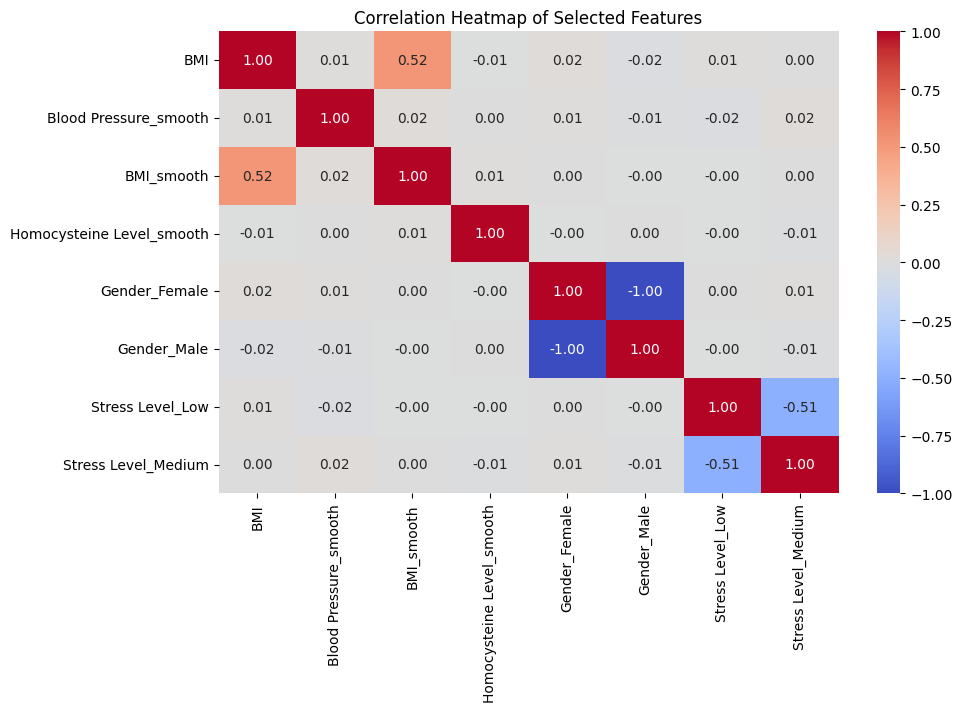

In [ ]:
# ---------------- Correlation Heatmap ----------------
# Transform the full dataset (after preprocessing)
X_transformed = pipeline.named_steps["preprocessor"].transform(X)

# Build a DataFrame with encoded + numeric features
X_transformed_df = pd.DataFrame(
    X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed,
    columns=feature_names
)

# Keep only selected features
X_selected_df = X_transformed_df[selected_features]

# Plot correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(X_selected_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

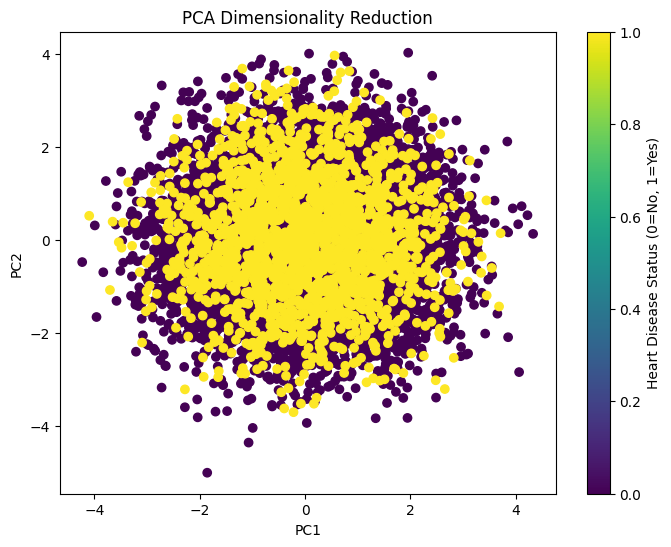

In [ ]:
# ---------------- PCA Dimensionality Reduction ----------------
# Run PCA on the preprocessed data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed)

# Encode target ("Yes"=1, "No"=0)
y_numeric = np.where(y == "Yes", 1, 0)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_numeric, cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Dimensionality Reduction")
plt.colorbar(label="Heart Disease Status (0=No, 1=Yes)")
plt.show()

# **SVM Classification Model Implementation**

In [ ]:
# 4) Prepare data for SVM classification
# ---------------------------------------
# Separate features and target
X = df.drop('Heart Disease Status', axis=1)
y = df['Heart Disease Status']

# Convert target to binary (0/1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Target classes: {le.classes_}")
print(f"Target distribution: {pd.Series(y_encoded).value_counts()}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")

# Check for class imbalance
class_counts = pd.Series(y_encoded).value_counts()
class_ratio = class_counts.max() / class_counts.min()
print(f"\n=== CLASS IMBALANCE ANALYSIS ===")
print(f"Class distribution: {dict(class_counts)}")
print(f"Class ratio (majority/minority): {class_ratio:.2f}")
if class_ratio > 3:
    print("⚠️  SEVERE CLASS IMBALANCE DETECTED!")
    print("   Using class_weight='balanced' to handle this issue.")
else:
    print("✅ Classes are reasonably balanced.")

In [ ]:
# 5) Create preprocessing pipeline
# ---------------------------------------
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {len(numerical_features)} features")

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing pipeline created successfully!")

In [ ]:
# 6) Split the data
# ---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training target distribution: {pd.Series(y_train).value_counts()}")
print(f"Test target distribution: {pd.Series(y_test).value_counts()}")

In [ ]:
# 7) Baseline SVM Model
# ---------------------------------------
print("=== BASELINE SVM MODEL ===")

# Create baseline SVM pipeline with class balancing
baseline_svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, class_weight='balanced'))
])

# Train the baseline model
print("Training baseline SVM model...")
baseline_svm_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_baseline = baseline_svm_pipeline.predict(X_test)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print(f"\nBaseline SVM Results:")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall: {baseline_recall:.4f}")
print(f"F1-Score: {baseline_f1:.4f}")

# Confusion Matrix
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=le.classes_))

## **Parameter Tuning using GridSearchCV**

In [ ]:
# 8) Parameter Tuning with GridSearchCV
# ---------------------------------------
print("=== PARAMETER TUNING WITH GRIDSEARCHCV ===")

# Define parameter grid for SVM with class balancing
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'classifier__class_weight': ['balanced', None]
}

# Create SVM pipeline for GridSearch
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

# Perform GridSearchCV
print("Performing GridSearchCV... This may take a few minutes.")
grid_search = GridSearchCV(
    svm_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Make predictions with best model
y_pred_grid = grid_search.predict(X_test)

# Calculate metrics for tuned model
grid_accuracy = accuracy_score(y_test, y_pred_grid)
grid_precision = precision_score(y_test, y_pred_grid)
grid_recall = recall_score(y_test, y_pred_grid)
grid_f1 = f1_score(y_test, y_pred_grid)

print(f"\nGridSearchCV Tuned SVM Results:")
print(f"Accuracy: {grid_accuracy:.4f}")
print(f"Precision: {grid_precision:.4f}")
print(f"Recall: {grid_recall:.4f}")
print(f"F1-Score: {grid_f1:.4f}")

# Confusion Matrix
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_grid))

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_grid, target_names=le.classes_))

# Compare with baseline
print(f"\n=== COMPARISON WITH BASELINE ===")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Tuned Accuracy: {grid_accuracy:.4f}")
print(f"Improvement: {grid_accuracy - baseline_accuracy:.4f}")

## **Manual Parameter Tuning**

In [ ]:
# 9) Manual Parameter Tuning
# ---------------------------------------
print("=== MANUAL PARAMETER TUNING ===")

# Based on GridSearch results, let's try some manual fine-tuning
# We'll test different combinations around the best parameters

manual_params = [
    {'C': 10, 'kernel': 'rbf', 'gamma': 0.1, 'class_weight': 'balanced'},
    {'C': 100, 'kernel': 'rbf', 'gamma': 0.01, 'class_weight': 'balanced'},
    {'C': 50, 'kernel': 'rbf', 'gamma': 0.05, 'class_weight': 'balanced'},
    {'C': 10, 'kernel': 'linear', 'class_weight': 'balanced'},
    {'C': 1, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale', 'class_weight': 'balanced'},
    {'C': 1, 'kernel': 'rbf', 'gamma': 1, 'class_weight': 'balanced'}
]

best_manual_score = 0
best_manual_params = None
best_manual_model = None

for i, params in enumerate(manual_params):
    print(f"\nTesting manual configuration {i+1}: {params}")
    
    # Create model with specific parameters
    manual_svm = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(random_state=42, **params))
    ])
    
    # Train and evaluate
    manual_svm.fit(X_train, y_train)
    y_pred_manual = manual_svm.predict(X_test)
    
    # Calculate accuracy
    manual_accuracy = accuracy_score(y_test, y_pred_manual)
    manual_precision = precision_score(y_test, y_pred_manual)
    manual_recall = recall_score(y_test, y_pred_manual)
    manual_f1 = f1_score(y_test, y_pred_manual)
    
    print(f"Accuracy: {manual_accuracy:.4f}")
    print(f"Precision: {manual_precision:.4f}")
    print(f"Recall: {manual_recall:.4f}")
    print(f"F1-Score: {manual_f1:.4f}")
    
    # Track best model
    if manual_accuracy > best_manual_score:
        best_manual_score = manual_accuracy
        best_manual_params = params
        best_manual_model = manual_svm

print(f"\n=== BEST MANUAL TUNING RESULTS ===")
print(f"Best manual parameters: {best_manual_params}")
print(f"Best manual accuracy: {best_manual_score:.4f}")

In [ ]:
# 10) Final Model Evaluation and Comparison
# ---------------------------------------
print("=== FINAL MODEL EVALUATION ===")

# Get predictions from best manual model
y_pred_final = best_manual_model.predict(X_test)

# Calculate final metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)

print(f"\nFinal Model Results:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")

# Final Confusion Matrix
print(f"\nFinal Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

# Final Classification Report
print(f"\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=le.classes_))

# Summary comparison
print(f"\n=== SUMMARY COMPARISON ===")
print(f"Baseline SVM Accuracy: {baseline_accuracy:.4f}")
print(f"GridSearchCV Accuracy: {grid_accuracy:.4f}")
print(f"Manual Tuning Accuracy: {final_accuracy:.4f}")
print(f"\nTotal Improvement from Baseline: {final_accuracy - baseline_accuracy:.4f}")
print(f"Percentage Improvement: {((final_accuracy - baseline_accuracy) / baseline_accuracy * 100):.2f}%")

In [ ]:
# 11) Visualize Results
# ---------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Create comparison plot
models = ['Baseline SVM', 'GridSearchCV', 'Manual Tuning']
accuracies = [baseline_accuracy, grid_accuracy, final_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('SVM Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap for Final Model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Final Model Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n=== SVM CLASSIFICATION IMPLEMENTATION COMPLETE ===")
print(f"Final Model Parameters: {best_manual_params}")
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nThe SVM model has been successfully implemented with parameter tuning!")

In [5]:
!pip install numpy pandas matplotlib

^C


   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -----------------

   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [pandas]
   ----------------------------- ----------  8/11 [panda